# 0.3.2 Model Checkpoints

Before iterating through large quantities of models, we should figure out a good workflow for saving models at various checkpoints.

## Boilerplate

The following subsections are largely boilerplate code, so skip around as needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [2]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

Tue May 07 2019 15:52:28 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.3
seaborn 0.9.0
tensorflow 1.12.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-130-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : ded6540a0da1ae5a1d9648a102ddfea7da0ed892
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [3]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [4]:
# Set the matplotlib mode
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [11]:
# Standard library imports
import os
import logging
from pathlib import Path
from copy import deepcopy

# Third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf


Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [6]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cgh
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging
%aimport leabratf.constants
from leabratf.constants import DIR_CKPTS
%aimport leabratf.tasks.combinatorics.default_configuration
from leabratf.tasks.combinatorics.default_configuration import default_config

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [8]:
sns.set()
sns.set_context("notebook")

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [9]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger('leabratf')
# Don't propagate messages
logger.propagate = False

### Default Configuration

In [7]:
# Define the base experiment configuration
cfg = default_config()
# Overwrite any configuration values here
cfg.tf_device = '/device:CPU:0'

In [10]:
# Define a config dict constructor based on the cfg above
default_nb_config = lambda **kwargs: default_config(**deepcopy(cfg).update(**kwargs))
# Training set config
training_set_config = default_nb_config(_name='train')
print(training_set_config, type(training_set_config), sep='\n')

{'_config': True,
 '_name': 'train',
 'batch_size': 1,
 'dims': 2,
 'dir_checkpoints': PosixPath('/home/abdullah_rashed/work/projects/leabra-tf/models/checkpoints'),
 'dir_tensorboard': PosixPath('/home/abdullah_rashed/work/projects/leabra-tf/data/tensorboard'),
 'epochs': 500,
 'line_stats': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1]],
 'lr': 0.01,
 'n_epochs_acc': 25,
 'n_hidden_1': 100,
 'n_inputs': 100,
 'n_lines': 2,
 'n_models': 10,
 'n_outputs': 40,
 'n_samples': 100,
 'n_test': 500,
 'n_train': 100,
 'n_updates': 2,
 'n_val': 50,
 'optimizer': 'sgd',
 'size': 5,
 'slots': 4,
 'tf_device': '/device:CPU:0'}
<class 'pstar.pstar.pdict'>


### Global Variables

Same variables that characterize the task, network, and data.

#### Combigen Task Variables

In [10]:
# Number of slots in a training set
STACK = 4
# Size of each axis in the input array
SIZE = 5
# Number of axes to use per slot
DIMS = 2
# Number of lines per axis
LINES = [1,1]

#### Data Parameters

In [11]:
# Number of epochs to train for
EPOCHS = 500
# Number of samples in the training set
N_TRAIN= 100
# Number of samples in the validation set
N_VAL = 50
# Number of samples in the testing set
N_TEST = 500

#### Datasets

In [12]:
# Training Data
Y_TRAIN = cg.generate_labels(n_samples=N_TRAIN, stack=STACK, size=SIZE, dims=DIMS, n_lines=LINES)
X_TRAIN = cg.inverse_transform(Y_TRAIN)
# Validation Data
Y_VAL = cg.generate_labels(n_samples=N_VAL, stack=STACK, size=SIZE, dims=DIMS, n_lines=LINES)
X_VAL = cg.inverse_transform(Y_VAL)
# Testing data
Y_TEST = cg.generate_labels(n_samples=N_TEST, stack=STACK, size=SIZE, dims=DIMS, n_lines=LINES)
X_TEST = cg.inverse_transform(Y_TEST)

#### Network Parameters

In [13]:
# Learning rate
ALPHA = 0.01
# Batch size
BATCH_SIZE = 1
# Number of parameters in the inputs
N_INPUTS = STACK * SIZE ** DIMS
# Number of hidden units
N_HIDDEN_1 = 100
# Number of parameters in the labels
N_OUTPUTS = STACK * SIZE * DIMS

#### Training Parameters

In [14]:
# Number of times to print an update
N_UPDATES = 2
# Which device to train on
TF_DEVICE = '/cpu:0'
# Number of models to train with
N_MODELS = 10

## Background

This section goes over some of the background information for the notebook using results from previous notebooks. Skip around as needed.

### The Combigen Task

Quickly remind ourselves what the task looks like before diving in.

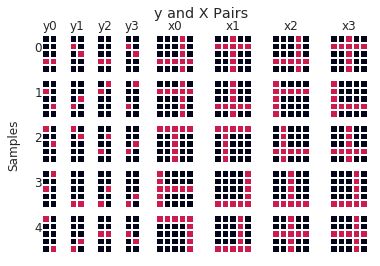

In [15]:
cgh.visualize_combigen(5)
plt.show()

## Setting Up the Graph

This next section will define the computational graph that will be used to generate the metrics down below. It is largely code copied from nb-0.3, so skip around as needed.

In [33]:
# Cleanup any residual nodes
tf.reset_default_graph()

### Make the Datasets

Define the various `tf.Dataset`s that will be used.

In [34]:
def make_tf_datasets(init_ops=None):
    # The first step of the setup is that each of the datasets (training, validation, and 
    # testing) are turned into their own `Dataset` objects.
    # Training dataset
    dataset_train = tf.data.Dataset.from_tensor_slices(
        (X_TRAIN, Y_TRAIN)).repeat().batch(BATCH_SIZE)
    # Validation dataset
    dataset_val = tf.data.Dataset.from_tensor_slices(
        (X_VAL, Y_VAL)).repeat().batch(N_VAL)
    # Testing dataset
    dataset_test = tf.data.Dataset.from_tensor_slices(
        (X_TEST, Y_TEST)).repeat().batch(N_TEST)
    
    # Next, let's define the iterators for each of the datasets, and then add their 
    # initializations to the `init_ops` list.
    # Training iterator
    train_iter = dataset_train.make_initializable_iterator()
    # Validation iterator
    val_iter = dataset_val.make_initializable_iterator()
    # Testing iterator
    test_iter = dataset_test.make_initializable_iterator()
    # Aggregate the iterators
    iterators = [train_iter, val_iter, test_iter]

    # Add the initiatlizations to the init opts
    init_ops = init_ops or []
    init_ops += [train_iter.initializer, val_iter.initializer, test_iter.initializer]
    
    # And finally, the interesting part. Rather than creating separate next elements for 
    # the model, the `tf.data` API has a string handler iterator so we can contextually 
    # switch the active `Dataset` object, resulting in different values being used for `x` 
    # and `y`.

    # The way this is done is by defining a `tf.placeholder` variable, which is used 
    # first to create a string handler iterator, and later to hold the dataset-indicating 
    # string handle. The string handler iterator is what then changes the values of `x` and 
    # `y`, naturally also supplying them using the `get_next` method.
    # The placeholder variable of type string
    handle = tf.placeholder(tf.string, shape=[])
    # Iterator from string handle
    handle_iterator = tf.data.Iterator.from_string_handle(
        handle, dataset_train.output_types, 
        dataset_train.output_shapes)

    # x and y that will be used in the graph
    x, y = handle_iterator.get_next()
    
    return x, y, iterators, handle, init_ops

### TF Variables

Straight forward section where we define the weights and biases. One thing to note is that the weights are initialized using the `tf.contrib.layers.xavier_initializer`. 

Additionally, create an empty list that will contain the initialization operations to be performed at the start of a session.

In [35]:
# Weights and biases
weights = {
    'h1': tf.get_variable(name='w_h1', shape=[N_INPUTS, N_HIDDEN_1],
                      initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable(name='w_out', shape=[N_HIDDEN_1, N_OUTPUTS],
                      initializer=tf.contrib.layers.xavier_initializer()),
}
biases = {
    'b1': tf.get_variable(name="b_1", shape=[N_HIDDEN_1], 
                      initializer=tf.zeros_initializer()),
    'out': tf.get_variable(name="b_out", shape=[N_OUTPUTS], 
                      initializer=tf.zeros_initializer()),
}

init_ops = []

### Model, Loss Function, and Metrics

The architecture is the same as previous notebooks. See `nb-0.3` for more details.

In [36]:
def oreilly_model(inputs):
    # Reshape for hidden layer
    inputs = tf.reshape(inputs, shape=[-1, N_INPUTS])
    # Single hidden layer
    inputs = tf.sigmoid(tf.add(tf.matmul(inputs, weights['h1']), biases['b1']))
    # Output layer
    inputs = tf.add(tf.matmul(inputs, weights['out']), biases['out'])
    # Reshape for labels
    return tf.reshape(inputs, shape=[-1, STACK, SIZE, DIMS])

In [37]:
with tf.device(TF_DEVICE):
    # Get the relevant dataset nodes
    x, y, iterators, handle, init_ops = make_tf_datasets(init_ops)

    # Build the model
    logits = oreilly_model(x)
    # Ensure y is cast to the same type as logits
    labels = tf.cast(y, logits.dtype)
    
    # We will keep this in for now
    # Define alpha as placeholder variable
    alpha_ph = tf.placeholder(tf.float32, shape=[])

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits, labels=labels))

    # train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    train_op = optimizer.minimize(loss_op)
    
    # Define some intermediate nodes
    predictions = tf.sigmoid(logits)
    rounded_predictions = tf.round(predictions)
    equal_labels_and_preds = tf.equal(rounded_predictions, labels)
    
    # O'Reilly Accuracy 
    axis_acc = tf.reduce_all(equal_labels_and_preds, axis=(2))
    slot_acc = tf.reduce_all(axis_acc, axis=(2))
    sample_acc = tf.reduce_all(slot_acc, axis=(1))
 
    # Elemental Accuracy 
    el_acc_op = tf.reduce_mean(tf.cast(equal_labels_and_preds, tf.float16))
    # Axis Accuracy
    axis_acc_op = tf.reduce_mean(tf.cast(axis_acc, tf.float16))
    # Slot Accuracy
    slot_acc_op = tf.reduce_mean(tf.cast(slot_acc, tf.float16))
    # Sample Accuracy
    sample_acc_op = tf.reduce_mean(tf.cast(sample_acc, tf.float16))

### New Session Function

In the event that we do not want to immediately close sessions, we won't be using the context handler but will still need to grab new sessions as necessary. So let's quickly write a function that will properly run `sess.close()` if a previous session exists and then return a new `tf.Session` instance.

In [488]:
def new_session(*args, **kwargs):
    # Try to close the globally defined session if it isn't already
    try:
        if not sess._closed:
            sess.close()
    # If it doesn't exist, then just pass
    except NameError:
        pass
    # Return the new instance
    return tf.Session(*args, **kwargs)

### Training the Model

Let's define a function that runs the training routine and accepts the number of epochs as the inputs.

In [509]:
def train(sess, lr=ALPHA, epochs=EPOCHS, n_updates=N_UPDATES, init_ops=None):
    # Ensure this is an int
    epochs = int(epochs)
    # Dict with the various metrics we care about
    metrics = {'loss':[], 'el_acc':[], 'ax_acc':[], 'sl_acc':[], 'sm_acc':[], 
               'val_loss':[], 'val_el_acc':[], 'val_ax_acc':[], 'val_sl_acc':[], 
               'val_sm_acc':[]}
    # Run the initialization ops
    init_ops = init_ops or []
    init_ops += [tf.global_variables_initializer(), tf.local_variables_initializer()]
    sess.run(init_ops)
    # Define training and validation handlers
    training_handle, validation_handle, testing_handle = sess.run([i.string_handle() 
                                                                   for i in iterators])

    for epoch in range(epochs):
        ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc = np.zeros([5, N_TRAIN])
        # Run the training steps
        for i in range(N_TRAIN):
            _, ep_loss[i], ep_el_acc[i], ep_sl_acc[i], ep_ax_acc[i], ep_sm_acc[i] = sess.run(
                [train_op, loss_op, el_acc_op, axis_acc_op, slot_acc_op, sample_acc_op],
                feed_dict={handle: training_handle, alpha_ph: lr})
            
        # Get means for the epoch
        epoch_data = list(np.mean((ep_loss, ep_el_acc, ep_sl_acc, ep_ax_acc, ep_sm_acc), 
                                  axis=1))

        # Calculate validation accuracy and loss
        val_data = list(sess.run([loss_op, el_acc_op, axis_acc_op, slot_acc_op, sample_acc_op],
                                 feed_dict={handle: validation_handle}))
        
        # Record
        for key, value in zip(metrics.keys(), epoch_data + val_data):
            metrics[key].append(value)

        # Selectively display the epoch number
        if n_updates and (not epoch % (epochs / n_updates) or epoch == epochs - 1):
            print(("Completed epoch {0}/{1}. Metrics:\n" + 
                   "                     Loss   Sample Accuracy   Elem Accuracy\n" +
                   "    Epoch:      {2:10.4f}   {3:10.4f}   {4:10.4f}\n" +
                   "    Validation: {5:10.4f}   {6:10.4f}   {7:10.4f}\n").format(
                epoch+1, epochs, epoch_data[0],epoch_data[4], epoch_data[1], 
                val_data[0], val_data[4], val_data[1]))

    # Calculate accuracy for test images
    print("Optimization Finished! Testing Sample Accuracy:", sess.run(
        sample_acc_op, feed_dict={handle: testing_handle}))
    return metrics

And now let's train for `EPOCHS` epochs.

In [503]:
%%time
sess = new_session()
metrics = train_or_model(sess, epochs=EPOCHS)

Completed epoch 1/50. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.7072       0.0000       0.5708
    Validation:     0.6705       0.0000       0.6260

Completed epoch 11/50. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.5040       0.0000       0.7998
    Validation:     0.5096       0.0000       0.7998

Completed epoch 21/50. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.4888       0.0000       0.7998
    Validation:     0.5007       0.0000       0.7998

Completed epoch 31/50. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.4834       0.0000       0.7998
    Validation:     0.4981       0.0000       0.7998

Completed epoch 41/50. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.4789       0.0000       0.7998
    Validation:     0.4954       0.0000       0.7998

Completed epoch 50/50

## Recreating the BCE+E Training Curves

Just like before, let's plot the training curves using the metrics we obtained. To do this, let's borrow the same function we had earlier but make a slight adjustment to it works for plain dictionaries.

In [501]:
def plot_history(history):
    metrics = history if not hasattr(history, 'history') else history.history
    for key, array in metrics.items():
        plt.plot(array, label=key)
    plt.title('Training History')
    plt.xlabel('Epochs')
    if len(array) > EPOCHS:
        plt.axvline(EPOCHS, linestyle='--', label='500 Epochs')
    plt.legend()

This function will now work for both keras history objects and dictionaries.

### 500 Epochs

Start the plot for just 500 epochs.

In [ ]:
%%time
sess = new_session()
metrics = train_or_model(sess, epochs=EPOCHS)

Completed epoch 1/500. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.7023       0.0000       0.5130
    Validation:     0.6680       0.0000       0.5752

Completed epoch 101/500. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.4520       0.0000       0.7998
    Validation:     0.4764       0.0000       0.7998



In [ ]:
plot_history(metrics)
plt.show()

### 10 x 500 Epochs

Let's recreate the same plot shown above for the O'Reilly model when running for ten times as many epochs.

In [526]:
%%time
sess = new_session()
metrics = train_or_model(sess, epochs=10*EPOCHS)

Completed epoch 1/5000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.6818       0.0000       0.5827
    Validation:     0.6557       0.0000       0.6128



KeyboardInterrupt: 

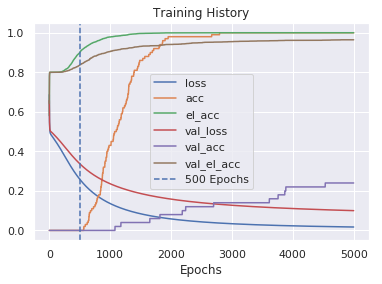

In [511]:
plot_history(metrics)
plt.show()

### 50 x 500 Epochs

It looks as though the model is still continuing to learn as shown by the increasing validation accuracy and falling validation loss. So train it for even longer.

In [512]:
metrics_1 = train_or_model(sess, epochs=50*EPOCHS)

Completed epoch 1/25000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.7033       0.0000       0.5765
    Validation:     0.6728       0.0000       0.5991

Completed epoch 5001/25000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.0175       1.0000       1.0000
    Validation:     0.1010       0.2000       0.9648

Completed epoch 10001/25000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.0074       1.0000       1.0000
    Validation:     0.0783       0.3000       0.9727

Completed epoch 15001/25000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.0046       1.0000       1.0000
    Validation:     0.0692       0.3401       0.9761

Completed epoch 20001/25000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.0033       1.0000       1.0000
    Validation:     0.0640       0.3401       0.9

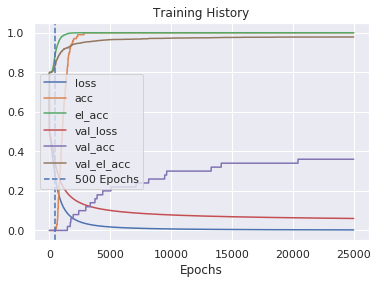

In [515]:
plot_history(metrics_1)
plt.show()